In [1]:
import numpy as np
import scipy as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

sns.set_context('notebook')

# %matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 200
sns.set(context='poster',
        style='ticks',
        font_scale=1,
        rc={'axes.grid':True,
            'grid.color':'.9',
            'grid.linewidth':0.75})
%load_ext autoreload
%autoreload 2

dev = 'cuda'
root = '/home/ubuntu/ext_vol'
import sys
sys.path.insert(0, f'{root}/inpca')

from utils import get_data, get_idx

In [2]:
import plotly.graph_objects as go
import numpy as np
import plotly.offline as pyo
import pandas as pd
pyo.init_notebook_mode()

In [17]:
def fn_from_config(c, root='/home/ubuntu/ext_vol/inpca/results/models/loaded/'):
    if c[0] == 0:
        return '/home/ubuntu/ext_vol/inpca/results/models/loaded/{"seed":0,"bseed":-1,"aug":"na","m":"geodesic","bn":"na","drop":"na","opt":"geodesic","bs":"na","lr":"na","wd":"na","interp":false}.p'
    else:
        if len(c) == 7:
            corner=c[-1]
        else:
            corner = 'normal'
        dic = {'seed':int(c[0]), 'bseed':-1, 'aug':c[1], 'm':c[2], 
                    'bn':True, 'drop':0.0, 'opt':c[4], 'bs':int(c[5]), 'lr':float(c[3]), 'wd':float(c[6]),
                    'corner':corner, 'interp':False}
        root = '/home/ubuntu/ext_vol/inpca/results/models/loaded/'
        fn = json.dumps(dic).replace(' ', '') + '.p'
        return os.path.join(root, fn)

## interp models

In [157]:
loc = '/home/ubuntu/ext_vol/inpca/results/models/loaded/'
loc_interp = '/home/ubuntu/ext_vol/inpca/results/models/reindexed_new'
d1 = {'seed': 42,
 'bseed': -1,
 'aug': 'none',
 'm': 'allcnn',
 'bn': True,
 'drop': 0.0,
 'opt': 'adam',
 'bs': 200,
 'lr': 0.001,
 'wd': 0.0,
 'corner': 'normal', 
 'interp': False}
d2 = {'seed': 42,
 'bseed': -1,
 'aug': 'none',
 'm': 'allcnn',
 'bn': True,
 'drop': 0.0,
 'opt': 'adam',
 'bs': 1000,
 'lr': 0.0025,
 'wd': 0.0,
 'corner': 'normal', 
 'interp': False}
all_f = []
for seed in range(42, 52):
    for interp in [False, True]:
        for d in [d1, d2]:
            if interp:
                d_ = {**d, 'seed':seed,  'interp':interp}
                del d_['corner']
                fn = json.dumps(d_).replace(" ", "")
                all_f.append(os.path.join(loc_interp, f"{fn}.p"))
            else:
                fn = json.dumps({**d, 'seed':seed, 'interp':interp}).replace(" ", "")
                all_f.append(os.path.join(loc, f"{fn}.p"))

In [158]:
len(all_f)

40

In [159]:
from utils import load_d
d = load_d(all_f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:21<00:00,  2.05s/it]


In [160]:
yh = np.stack(d.yh)

In [162]:
from utils import dbhat
w = dbhat(th.Tensor(yh), th.Tensor(yh), chunks=900)

torch.Size([3340, 50000, 10]) torch.Size([3340, 50000, 10])


In [163]:
from embed import proj_
l = np.eye(w.shape[0]) - 1.0/w.shape[0]
w = -l @ w @ l / 2
r = proj_(w, w.shape[0], 3)

Projecting


In [164]:
r['diag'] = np.diag(w)
r['tr'] = np.trace(w)
r['fn'] = np.linalg.norm(w, 'fro')

In [165]:
d['interp'] = d['interp'].astype(str)

fig = plotly_3d(dc=d.reset_index(drop=True), r=r, 
                    opacity=0.25,
                    colorscale='Set1',
                    ne=5, return_d=True,
                    color='interp',mode='markers', 
                    xrange=[-1, 0.75],
                    yrange=[-0.75, 0.75],
                    zrange=[-0.75, 0.75])
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=-0.2, y=0, z=0),
    eye=dict(x=2.55, y=2.65, z=2.85)
)
fig.update_layout(scene_camera=camera)
fig.show()

[ 3.01338820e+02  1.35528579e+01  3.47859640e+00 -2.48650862e+00
  2.19157161e+00 -1.37524936e-01 -6.20334392e-02 -6.15982278e-02
 -5.10653982e-02]


In [166]:

ii = np.argsort(r['e'])[::-1]
es = r['e'][ii]
vs = r['v'][:, ii]
b = r['diag']
tr = r['tr']

df = []
for i in range(len(es)):
    tr = 2*(r['tr'] - es[:i].sum())**2
    bnorm = 2*len(vs)*((b - (es[:i]*(vs[:, :i]**2)).sum(1))**2).sum()
    Bf = 4*(r['fn']**2 - (es[:i]**2).sum())
    df.append(tr+bnorm+Bf)

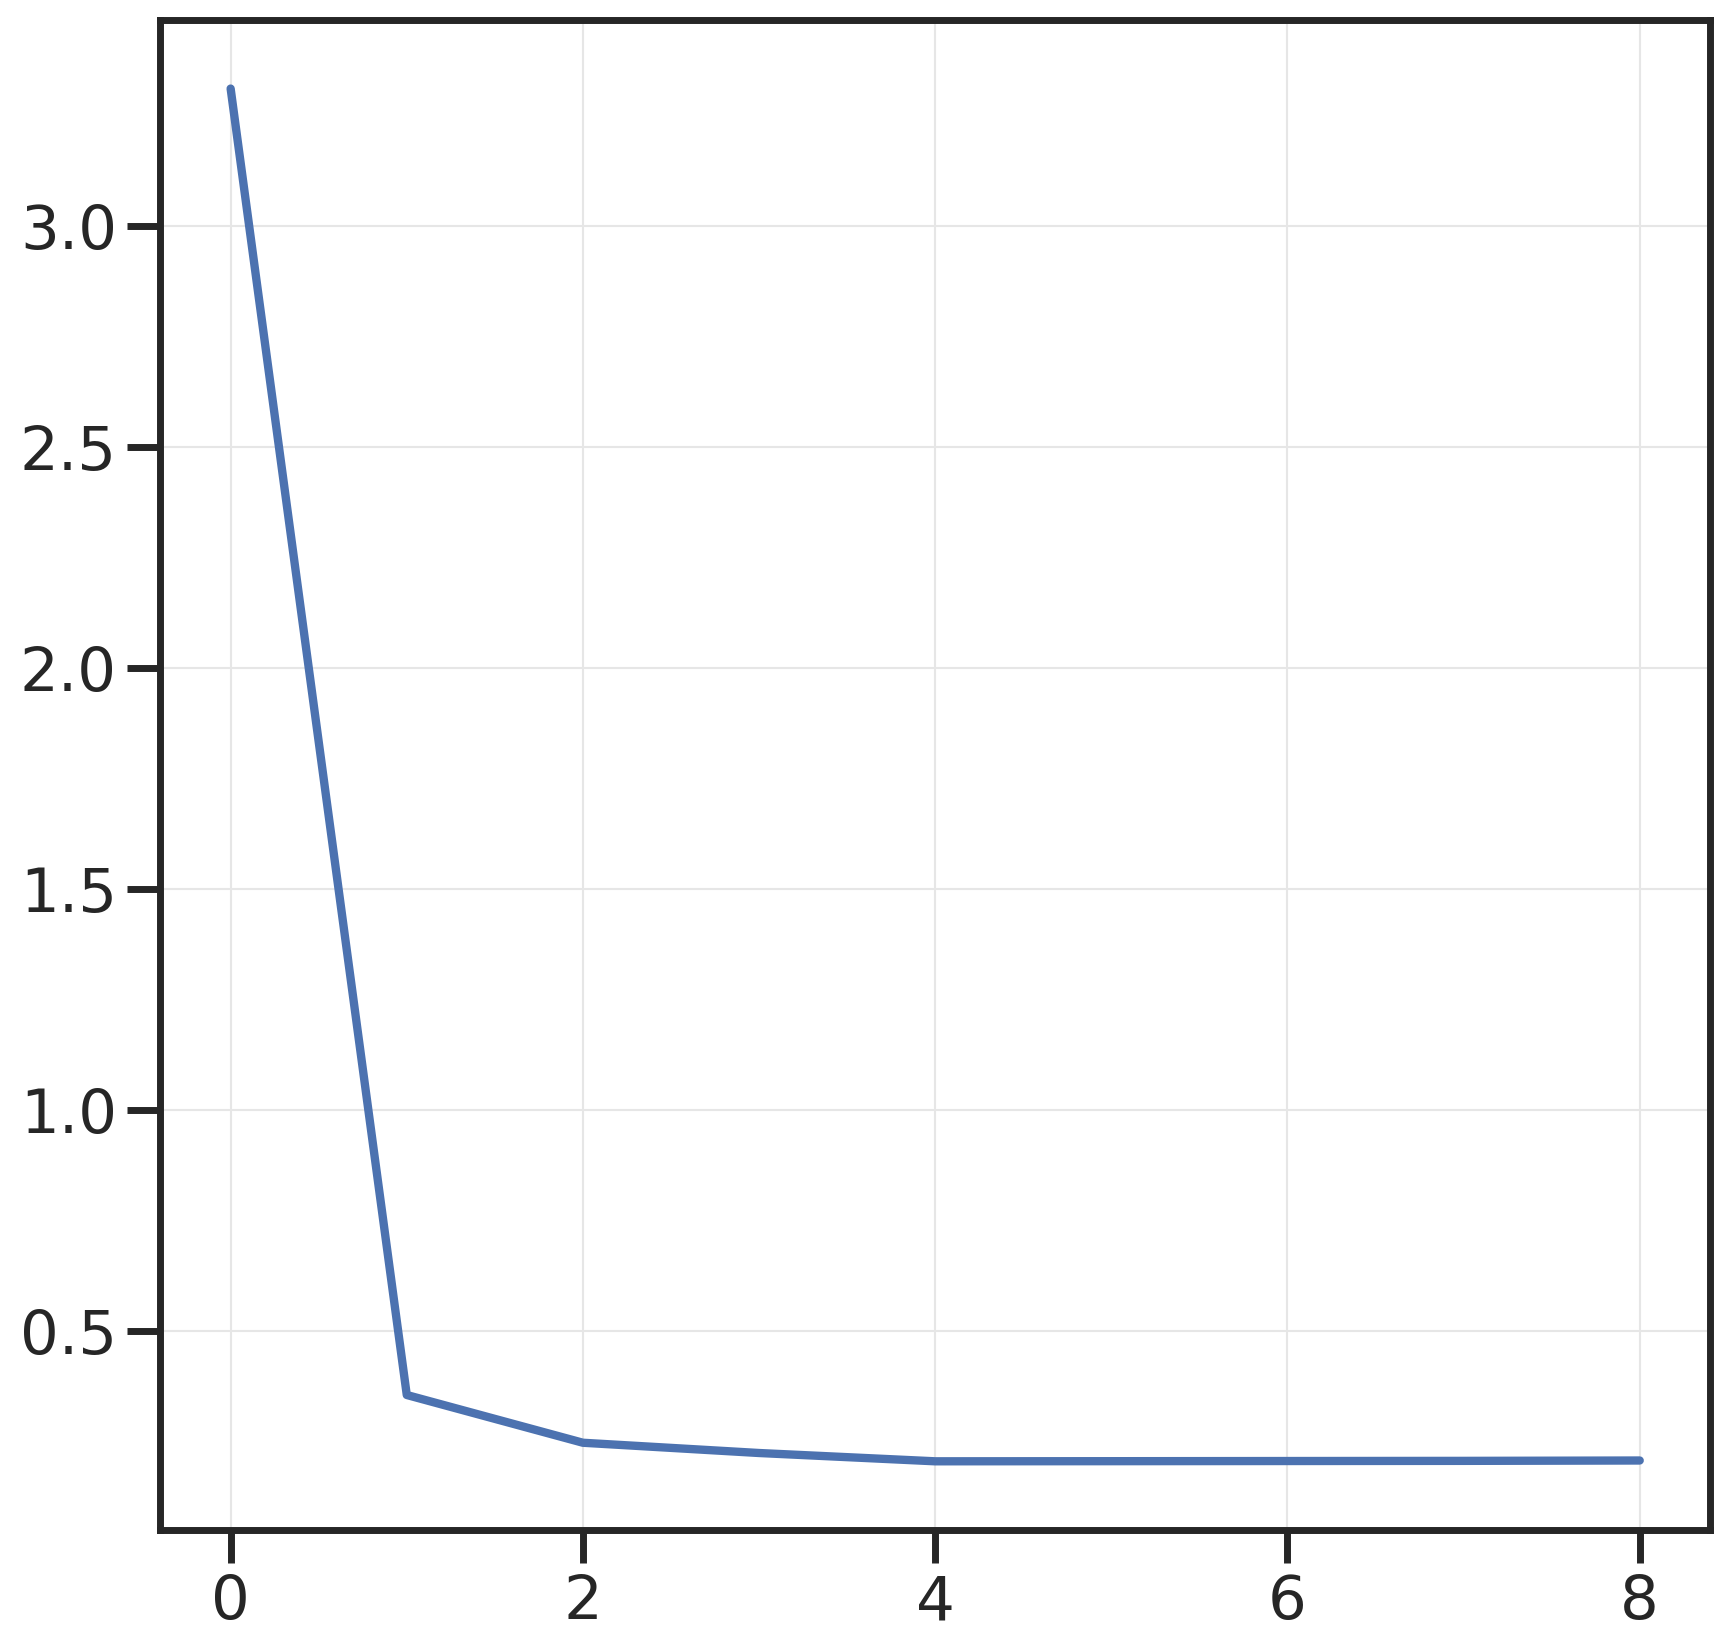

In [167]:
plt.plot(np.sqrt(df/(r['fn'])**2))

## model on val data

In [3]:
d2geod = th.load('d2geod.p')

In [32]:
import h5py
with h5py.File('/home/ubuntu/ext_vol/inpca/inpca_results_all/w_yh_all_geod.h5', 'r+') as f:
    w = f['w']
    w[-100:, :] = d2geod

In [15]:
geod = th.load('/home/ubuntu/ext_vol/inpca/results/models/loaded/{"seed":0,"bseed":-1,"aug":"na","m":"geodesic","bn":"na","drop":"na","opt":"geodesic","bs":"na","lr":"na","wd":"na","interp":false}.p')

In [17]:
from utils import dbhat
key = 'yh'
cols = ['seed', 'aug', 'm', 'lr', 'opt', 'bs', 'wd']
didx = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_geod_all_progress.p').reset_index(drop=True)
ii = didx.groupby(cols).indices
d2geod = np.zeros([100, len(didx)])
for r in range(0, 2300, 100):
    didx_geod = th.load(f'/home/ubuntu/ext_vol/inpca/inpca_results_all/inpca_results/didx_{key}_geod_c{r}.p')['dc'].reset_index(drop=True)
    dd = th.load(f'/home/ubuntu/ext_vol/inpca/inpca_results_all/inpca_results/w_{key}_geod_c{r}.p')
    ii_geod = didx_geod.groupby(cols).indices
    for (c, ig) in ii_geod.items():
        if c[0] == 52 or c == (42, 'none', 'fc', 0.1, 'sgdn', 200, 0.0): 
            continue
        if (dd[:, ig] == 0).all():
            print(r, c)
            fn = fn_from_config(c)
            yh = np.stack(th.load(fn)[key]).squeeze()
            dh = np.stack(geod[key]).squeeze()
            dd[:, ig] = dbhat(th.tensor(np.exp(dh)).float(), th.tensor(np.exp(yh)).float())
        d2geod[:, ii[c]] = dd[:, ig]

0 (42, 'none', 'convmixer', 0.0005, 'adam', 200, 1e-05)
torch.Size([100, 50000, 10]) torch.Size([67, 50000, 10])
1100 (47, 'simple', 'wr-10-4-8', 0.25, 'sgd', 500, 0.001)
torch.Size([100, 50000, 10]) torch.Size([62, 50000, 10])
1900 (0, 'na', 'geodesic', 'na', 'geodesic', 'na', 'na')
torch.Size([100, 50000, 10]) torch.Size([100, 50000, 10])


In [26]:
import h5py
with h5py.File('/home/ubuntu/ext_vol/inpca/inpca_results_all/w_yvh_all_geod.h5', 'r+') as f:
    w = f['w']

In [134]:
didx_geod = th.load(f'/home/ubuntu/ext_vol/inpca/inpca_results_all/inpca_results/didx_yvh_geod_c1900.p')['dc'].reset_index(drop=True)
dd = th.load(f'/home/ubuntu/ext_vol/inpca/inpca_results_all/inpca_results/w_yvh_geod_c1900.p')

In [157]:
didx = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_geod_all_progress.p').reset_index(drop=True)

In [10]:
import json
diffs = []
cols = ['seed', 'aug', 'm', 'lr', 'opt', 'bs', 'wd']
for r in tqdm.tqdm(range(0, 2300, 100)):
    didx_geod = th.load(f'/home/ubuntu/ext_vol/inpca/inpca_results_all/inpca_results/didx_yh_geod_c{r}.p')['dc']
    ii_geod = didx_geod.groupby(cols).indices
    for c in ii_geod.keys():
        
        if c[2] == 'geodesic':
            continue
        fn = fn_from_config(c)
        try:
            d_saved = th.load(fn)[didx_geod.columns]
        except FileNotFoundError:
            print(fn)

        if not (didx_geod.iloc[ii_geod[c]].reset_index(drop=True) == d_saved).all().all():
            diffs.append((r,c))
            print(r, c)

  0%|                                                                                                                                                                                                                             | 0/23 [00:00<?, ?it/s]

0 (42, 'none', 'allcnn', 0.0005, 'adam', 200, 0.0)


  0%|                                                                                                                                                                                                                             | 0/23 [00:10<?, ?it/s]


KeyboardInterrupt: 

In [76]:
didx_geod = th.load(f'/home/ubuntu/ext_vol/inpca/inpca_results_all/inpca_results/didx_yvh_geod_c{r}.p')['dc']
ii_geod = didx_geod.groupby(cols).indices

In [78]:
c = (42, 'none', 'fc', 0.1, 'sgdn', 200, 0.0)
dic = {cols[i]:c[i] for i in range(1,len(c))}
dic.update({'seed':int(c[0]), 'bseed':-1, 'aug':c[1], 'm':c[2], 
            'bn':True, 'drop':0.0, 'opt':c[4], 'bs':int(c[5]), 'lr':float(c[3]), 'wd':float(c[6]),
            'corner':'normal', 'interp':False})
root = '/home/ubuntu/ext_vol/inpca/results/models/loaded/'
dic = {k:dic[k] for k in key_order}
fn = json.dumps(dic).replace(' ', '') + '.p'
d_saved = th.load(os.path.join(root, fn))[didx_geod.columns]

In [61]:
all_d = pd.DataFrame()
for r in range(0, 2300, 100):
    didx_geod = th.load(f'/home/ubuntu/ext_vol/inpca/inpca_results_all/inpca_results/didx_yvh_geod_c{r}.p')['dc']
    didx_geod['fn'] = r
    all_d = pd.concat([all_d, didx_geod])

In [64]:
for (c, ig) in all_d.groupby(cols).indices.items():
    if len(ig) > 100:
        print(all_d.iloc[ig])

      seed   m   opt        t      err    verr   bs   aug   lr   wd    fn
0       42  fc  sgdn      0.0  0.90066  0.9008  200  none  0.1  0.0     0
1       42  fc  sgdn      1.0  0.82988  0.8329  200  none  0.1  0.0     0
2       42  fc  sgdn     63.0  0.62428  0.6265  200  none  0.1  0.0     0
3       42  fc  sgdn    125.0  0.59994  0.6051  200  none  0.1  0.0     0
4       42  fc  sgdn    187.0  0.56256  0.5708  200  none  0.1  0.0     0
...    ...  ..   ...      ...      ...     ...  ...   ...  ...  ...   ...
6067    42  fc  sgdn  37750.0  0.00000  0.4225  200  none  0.1  0.0  1900
6068    42  fc  sgdn  41500.0  0.00000  0.4220  200  none  0.1  0.0  1900
6069    42  fc  sgdn  45250.0  0.00000  0.4216  200  none  0.1  0.0  1900
6070    42  fc  sgdn  49000.0  0.00000  0.4229  200  none  0.1  0.0  1900
6071    42  fc  sgdn  50000.0  0.00000  0.4214  200  none  0.1  0.0  1900

[134 rows x 11 columns]


In [66]:
w1 = th.load(f'/home/ubuntu/ext_vol/inpca/inpca_results_all/inpca_results/w_yvh_geod_c0.p')
w2 = th.load(f'/home/ubuntu/ext_vol/inpca/inpca_results_all/inpca_results/w_yvh_geod_c1900.p')

In [71]:
d1 = th.load(f'/home/ubuntu/ext_vol/inpca/inpca_results_all/inpca_results/didx_yvh_geod_c0.p')['dc']
d2 = th.load(f'/home/ubuntu/ext_vol/inpca/inpca_results_all/inpca_results/didx_yvh_geod_c1900.p')['dc']

In [56]:
yvh = np.stack(th.load('/home/ubuntu/ext_vol/inpca/results/models/loaded/{"seed":42,"bseed":-1,"aug":"none","m":"convmixer","bn":true,"drop":0.0,"opt":"adam","bs":200,"lr":0.0005,"wd":1e-05,"corner":"normal","interp":false}.p').yvh)

In [ ]:
dd = th.load('/home/ubuntu/ext_vol/inpca/results/models/loaded/{"seed":42,"bseed":-1,"aug":"none","m":"convmixer","bn":true,"drop":0.0,"opt":"adam","bs":200,"lr":0.0005,"wd":1e-05,"corner":"normal"}.p')

### check w_yvh

In [3]:
didx = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_geod_all_progress.p').reset_index(drop=False)

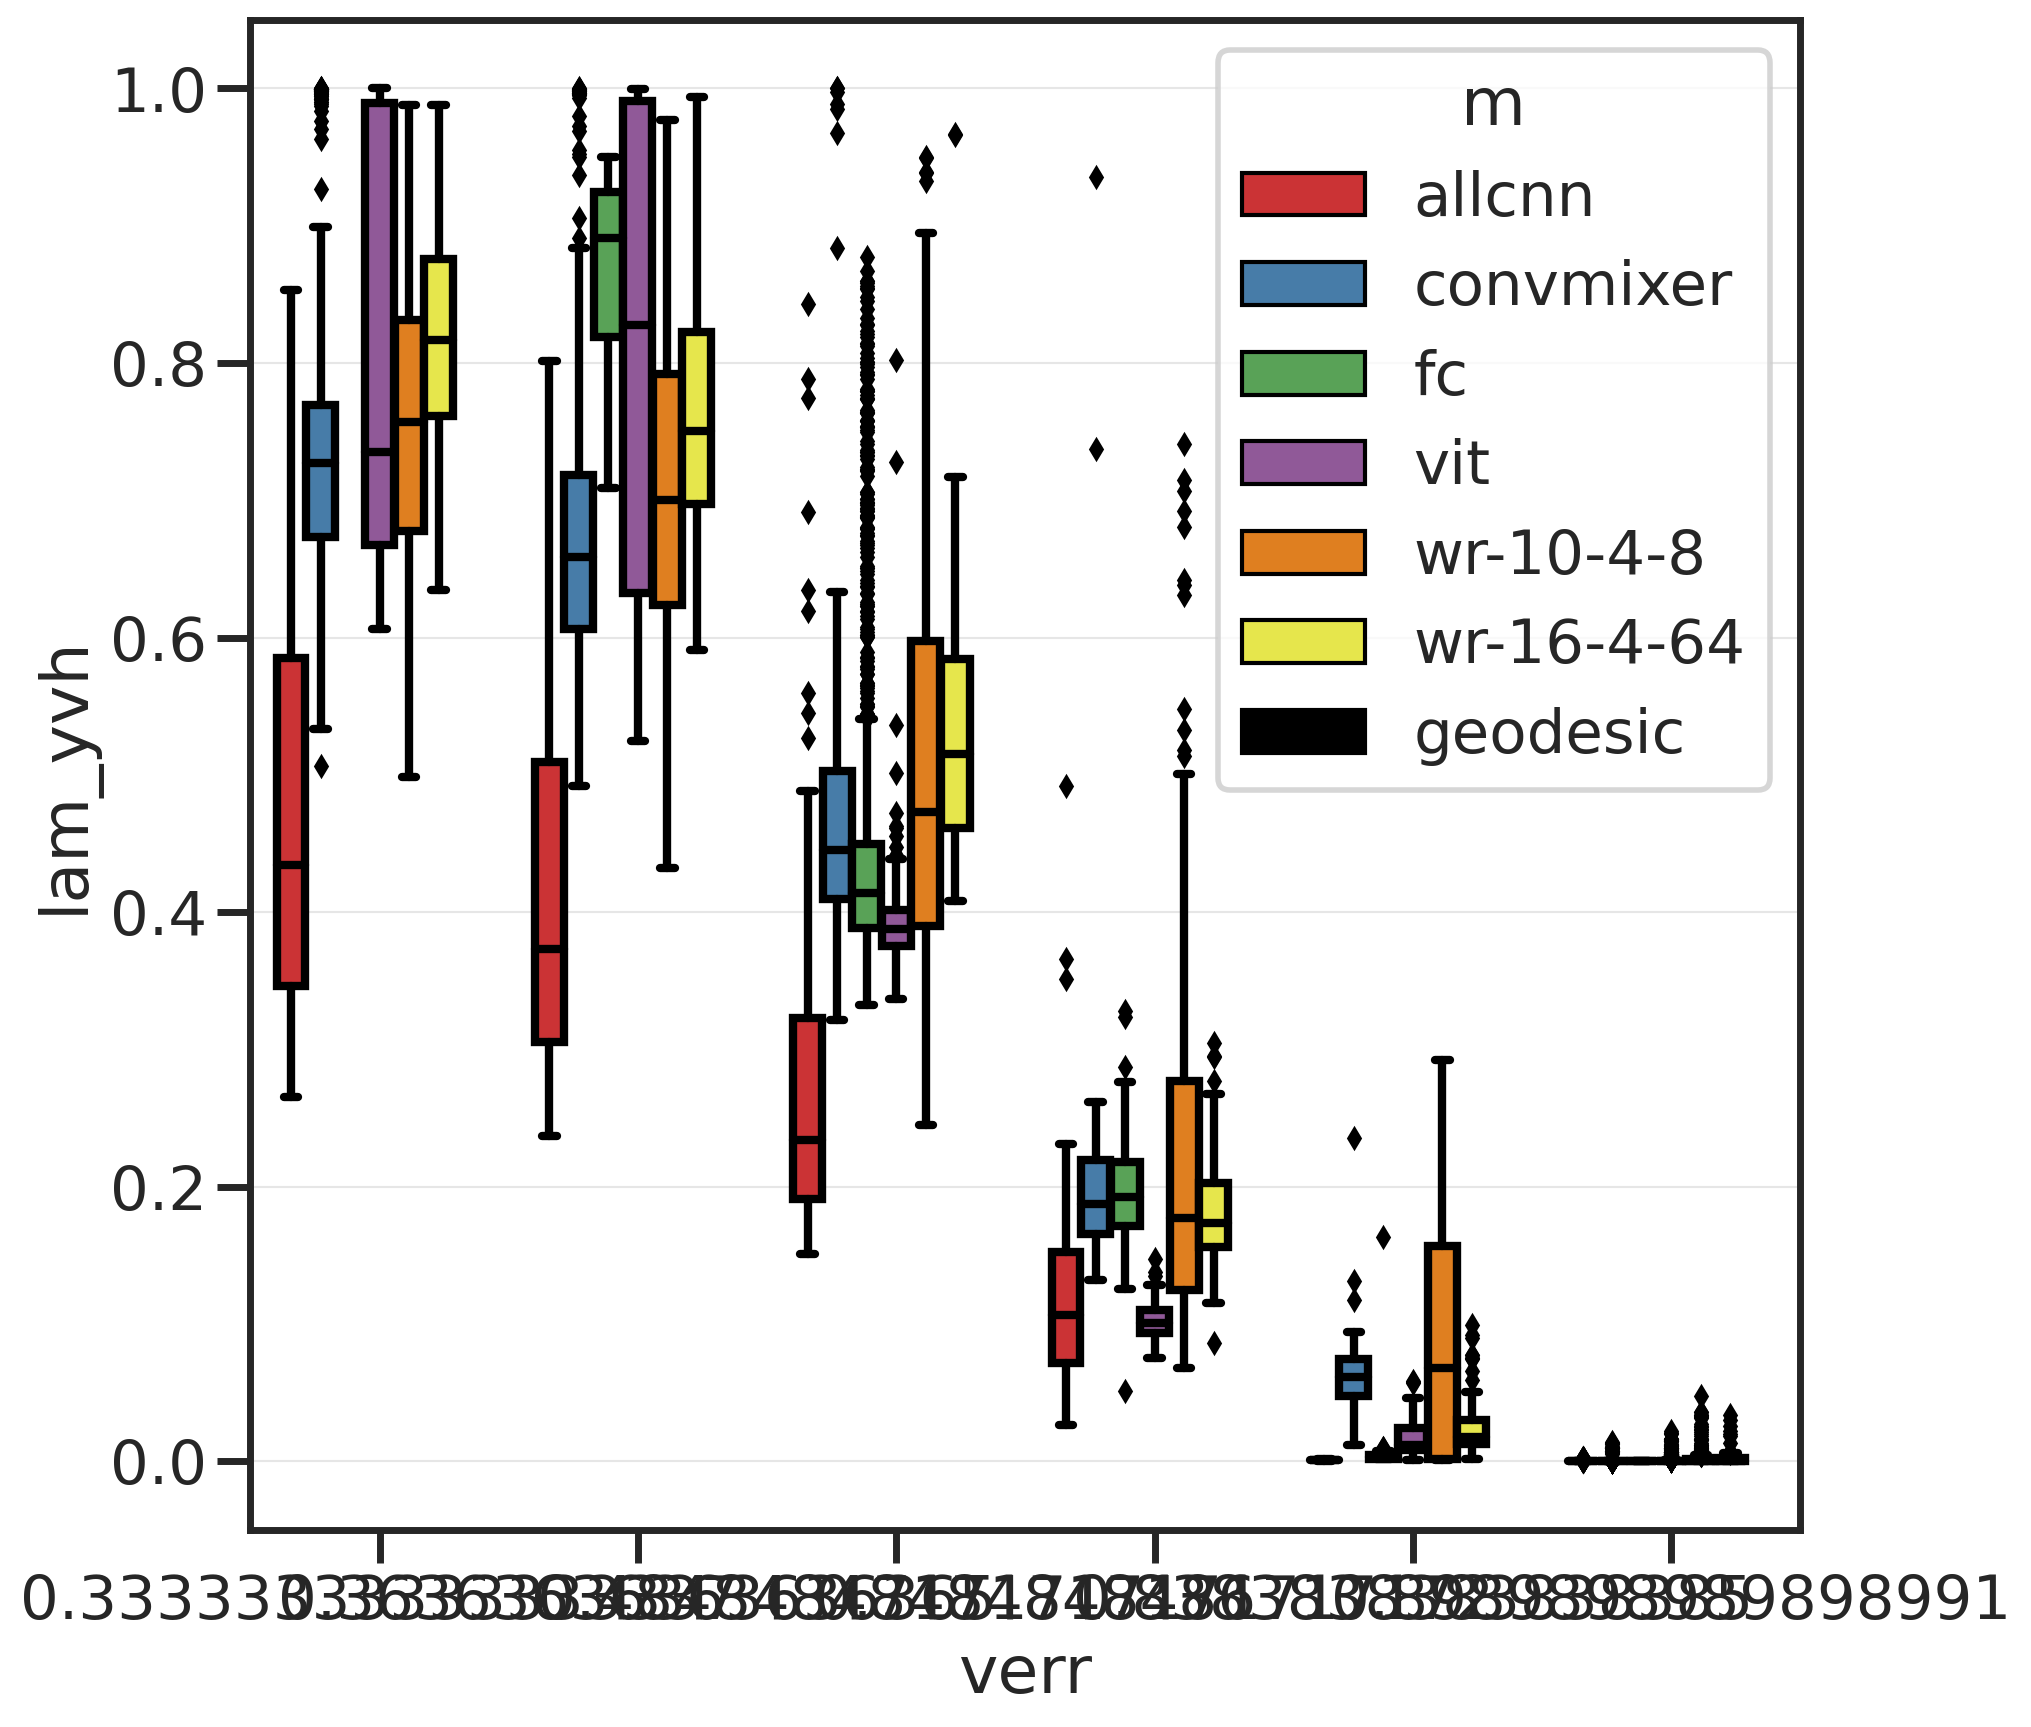

In [60]:
bins = np.linspace(0,1,100)
ind = np.digitize(didx['verr'], bins)
didx['verr'] = bins[ind-1]
ax=sns.boxplot(data=didx[didx.verr.isin(didx.verr.unique()[::15])].reset_index(), x='verr', y='lam_yvh', hue='m', palette=CDICT_M)

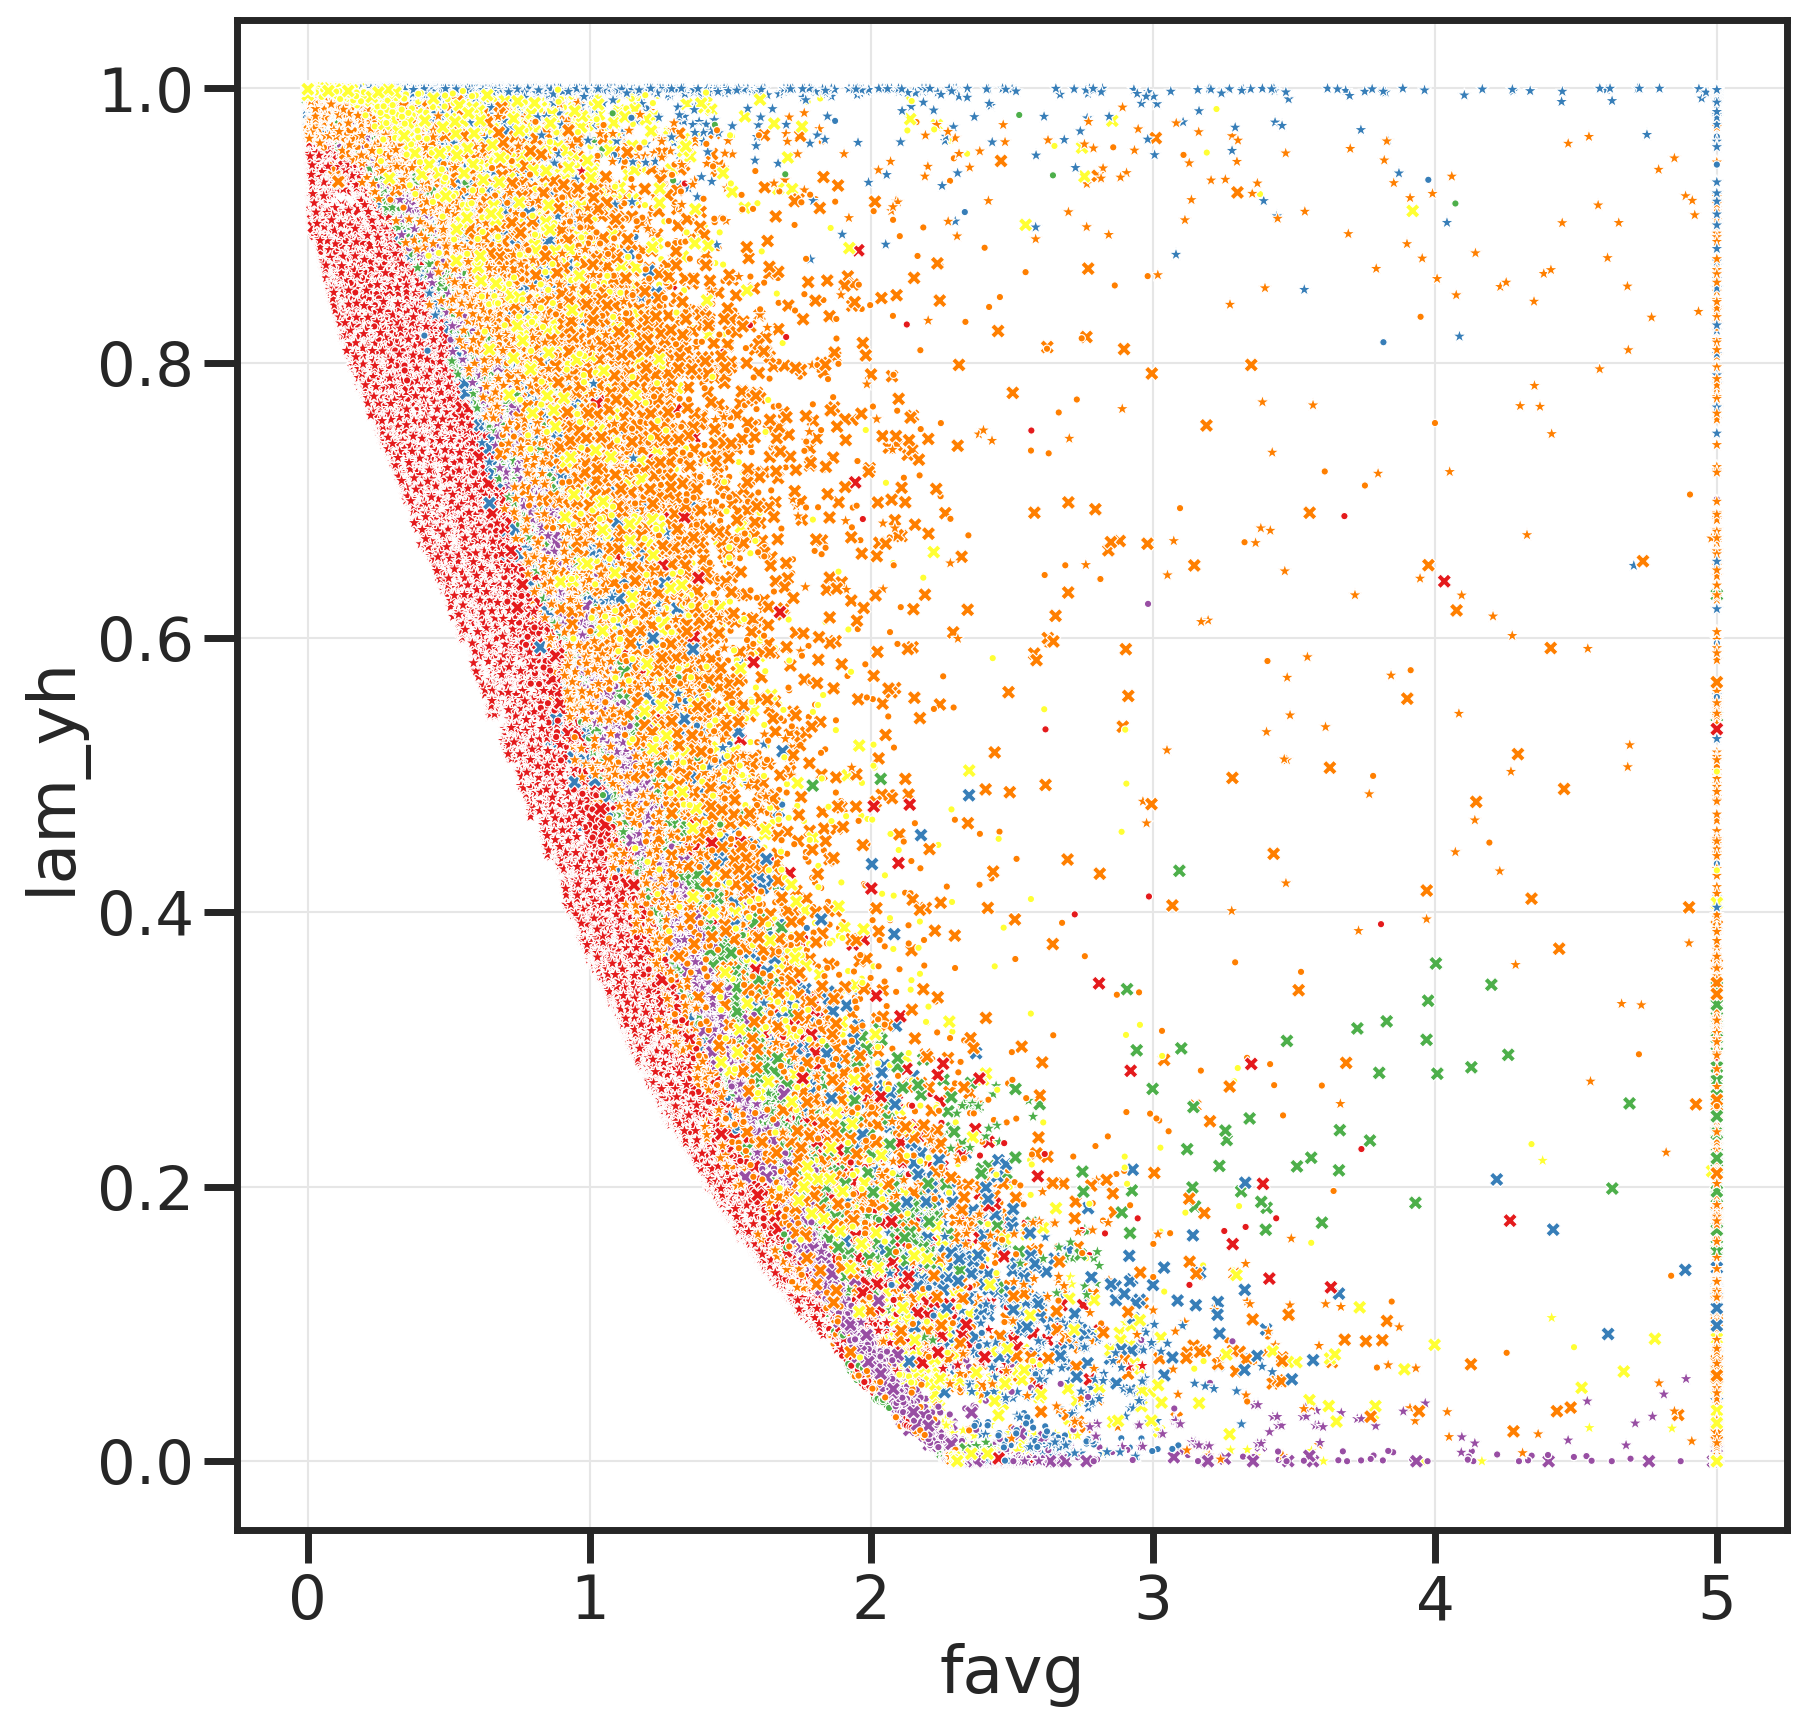

In [47]:
from utils import CDICT_M
didx['favg'] = np.clip(didx.favg, 0, 5)
ax=sns.scatterplot(data=didx, x='favg', y='lam_yh', hue='m', style='opt', legend=False, palette=CDICT_M, s=28,
                   markers=['.', 'X', '*','s'])
# sns.lineplot(x=np.linspace(0, 1, 100), y=1-np.linspace(0,1,100), ax=ax)

In [66]:
i1 = didx.groupby(cols).indices[(42, 'none', 'vit', '0.1', 'sgdn', '200', '0.0')]
i2 = didx.groupby(cols).indices[(46, 'none', 'vit', '0.1', 'sgdn', '200', '0.0')]

In [67]:
import h5py
with h5py.File('/home/ubuntu/ext_vol/inpca/inpca_results_all/w_yvh_all_geod.h5', 'r+') as f:
    w = f['w']
    sub_w = w[i1, :][:, i2]

In [68]:
didx.iloc[i2]

index  seed    m   opt        t      err      favg    verr     vfavg  \
70915  70915    46  vit  sgdn      0.0  0.90444  2.359199  0.9062  2.359128   
70916  70916    46  vit  sgdn      1.0  0.89180  6.947116  0.8896  6.941778   
70917  70917    46  vit  sgdn     63.0  0.88838  2.421917  0.8858  2.414423   
70918  70918    46  vit  sgdn    125.0  0.79876  2.092347  0.7945  2.085049   
70919  70919    46  vit  sgdn    187.0  0.78302  2.040825  0.7763  2.029252   
...      ...   ...  ...   ...      ...      ...       ...     ...       ...   
70977  70977    46  vit  sgdn  37750.0  0.00000  0.000004  0.3706  4.774046   
70978  70978    46  vit  sgdn  41500.0  0.00000  0.000004  0.3701  4.790859   
70979  70979    46  vit  sgdn  45250.0  0.00000  0.000003  0.3703  4.796379   
70980  70980    46  vit  sgdn  49000.0  0.00000  0.000003  0.3702  4.796875   
70981  70981    46  vit  sgdn  50000.0  0.00000  0.000003  0.3702  4.796877   

        bs  ...    length_yvh d2truth_yh d2init_yh d2truth_yvh  d2init_yvh  \
70915  200  ...  1.274398e-02   1.180718  0.012694    1.179580    0.012744   
70916  200  ...  7.527649e-01   2.000000  0.598445    3.447895    0.598027   
70917  200  ...  5.900882e-01   1.211055  0.052443    1.209316    0.051857   
70918  200  ...  1.098003e-01   1.046356  0.089179    1.046833    0.088641   
70919  200  ...  5.696877e-02   1.020038  0.099198    1.013846    0.098217   
...    ...  ...           ...        ...       ...         ...         ...   
70977  200  ...  3.866489e-05   0.000002  1.150683    2.429283    1.070787   
70978  200  ...  7.760294e-06   0.000002  1.150707    2.437867    1.071095   
70979  200  ...  1.123797e-06   0.000002  1.150714    2.440716    1.071200   
70980  200  ...  1.396896e-07   0.000002  1.150715    2.440986    1.071211   
70981  200  ...  3.278256e-08   0.000002  1.150715    2.440982    1.071210   

             x1        x2        x3        x4        x5  
70915  0.538457 -0.086461 -0.263842 -0.011257  0.037626  
70916  1.072794  0.332609 -0.105877  0.473763  0.037764  
70917  0.542067 -0.080953 -0.235357 -0.010838  0.102890  
70918  0.484997 -0.078422 -0.218933 -0.010196  0.031125  
70919  0.472474 -0.078580 -0.207104 -0.008127  0.024582  
...         ...       ...       ...       ...       ...  
70977 -0.762582  0.862288 -0.533064 -0.090236  0.247182  
70978 -0.763688  0.866030 -0.535324 -0.092696  0.248172  
70979 -0.764048  0.867247 -0.536059 -0.093490  0.248500  
70980 -0.764081  0.867356 -0.536125 -0.093561  0.248532  
70981 -0.764081  0.867356 -0.536124 -0.093561  0.248532  

[67 rows x 28 columns]

<AxesSubplot:>

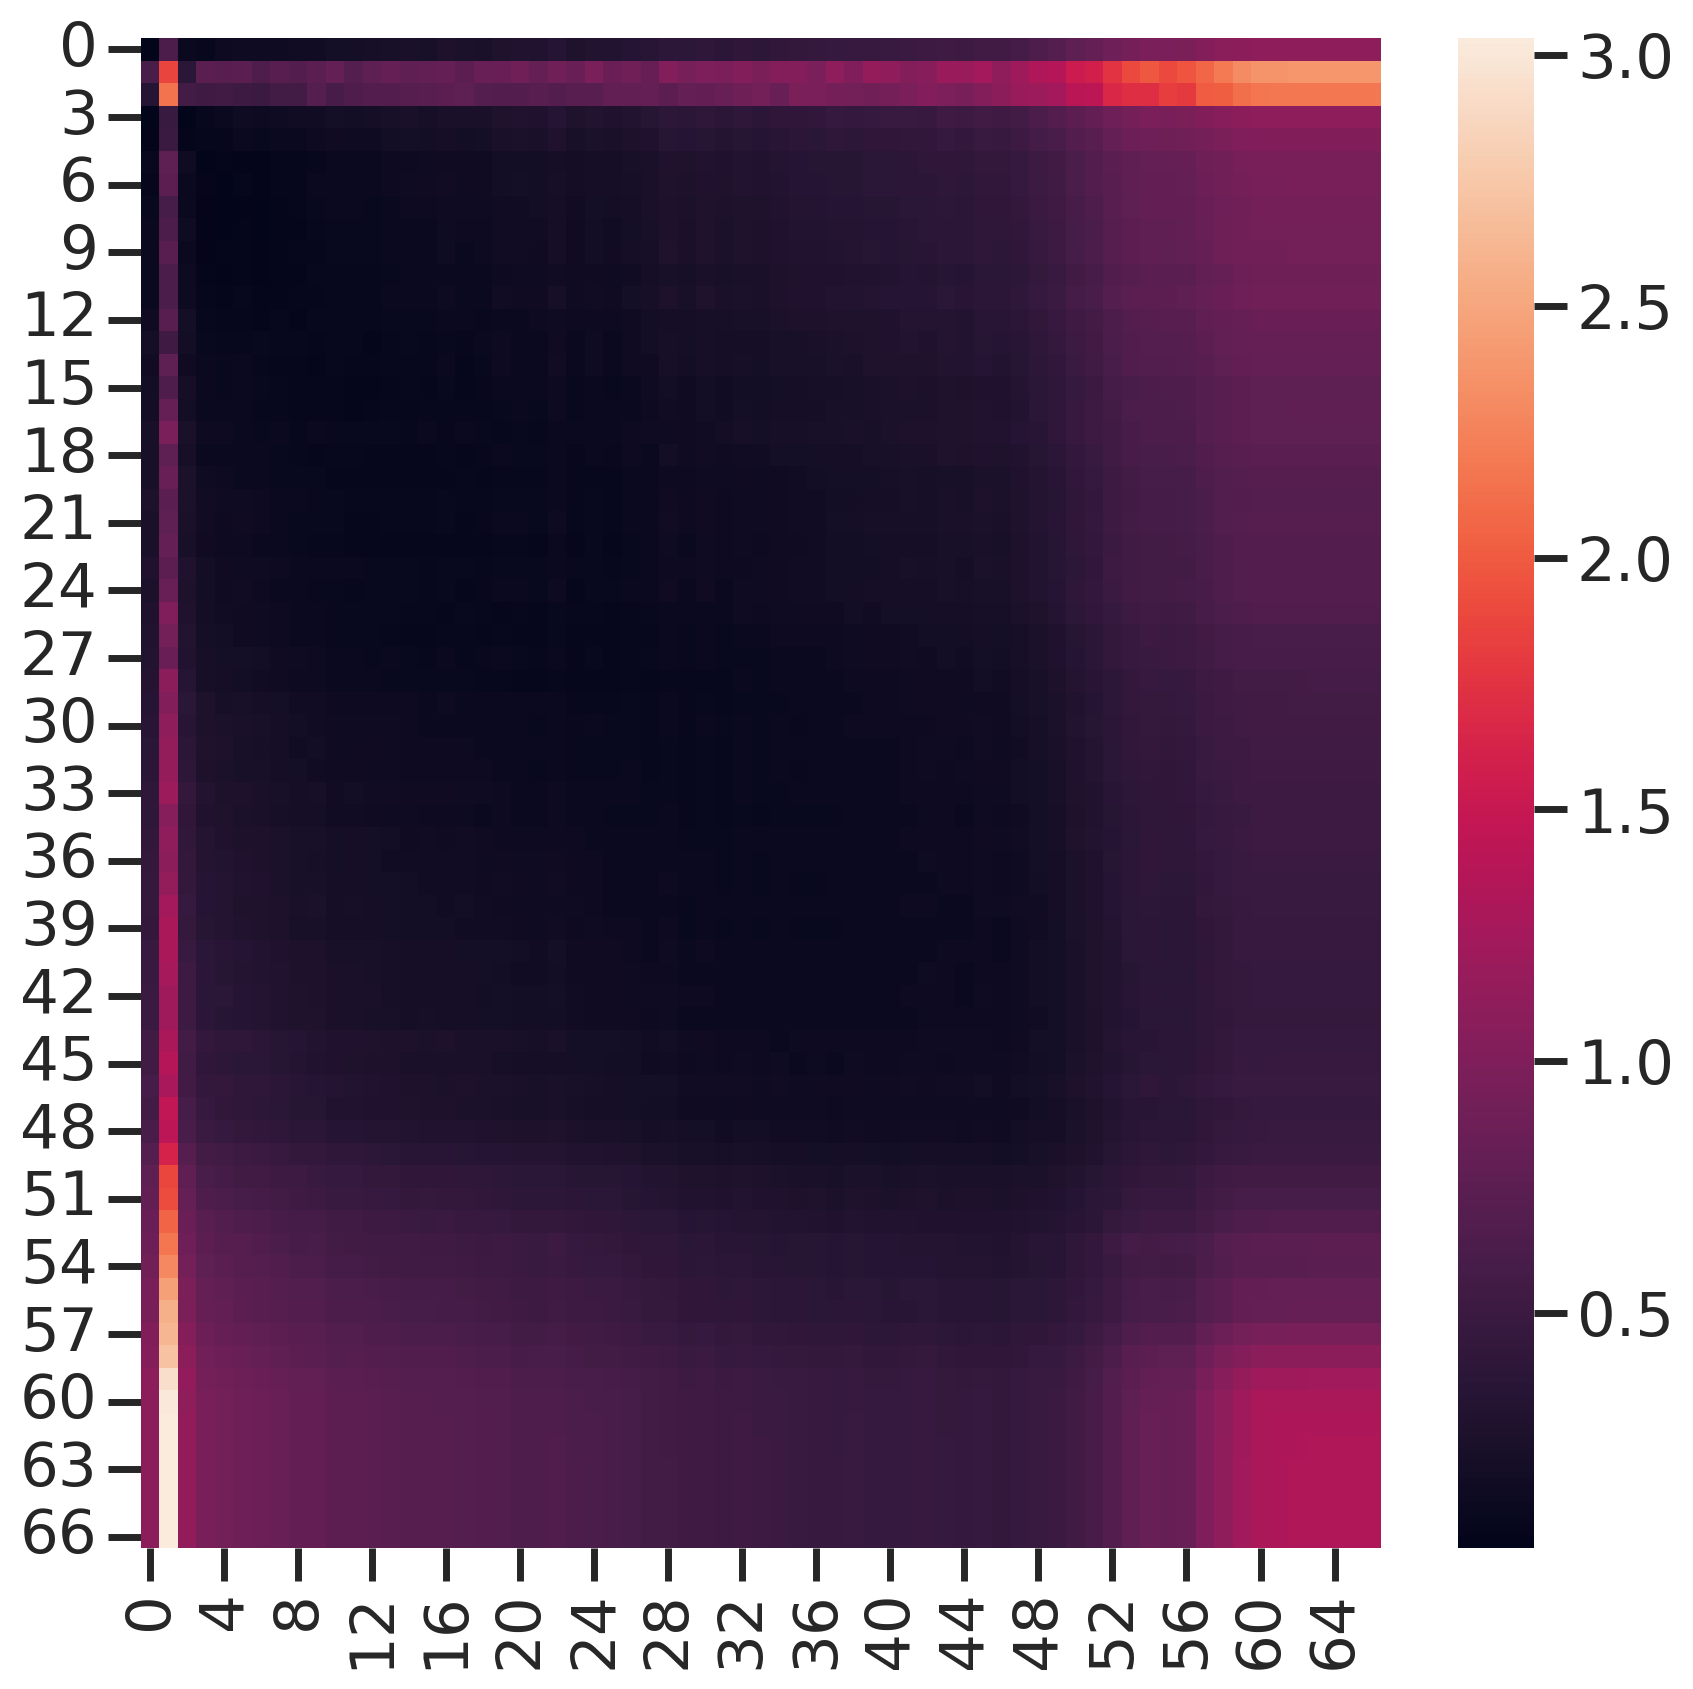

In [69]:
sns.heatmap(sub_w)

In [77]:
d1 = th.load(fn_from_config(c1))
d2 = th.load(fn_from_config((43, 'simple', 'fc', '0.5', 'sgdn', '1000', '0.0')))

In [78]:
yvh1 = np.stack(d1.yvh)
yvh2 = np.stack(d2.yvh)

In [79]:
from utils import dbhat
dd = dbhat(th.tensor(np.exp(yvh1)), th.tensor(np.exp(yvh2)))

torch.Size([73, 10000, 10]) torch.Size([73, 10000, 10])
